In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import *

In [142]:
df = pd.read_csv('vine.csv')
df.head(3)

,Unnamed: 0,Month,Fortified,Dry White,Sweet White,Red,Rose,Sparkling,Total,Average
0,0,1980-01-01,2585,1954,85,464,112.0,1686,6886.0,1147.666667
1,1,1980-02-01,3368,2302,89,675,118.0,1591,8143.0,1357.166667
2,2,1980-03-01,3210,3054,109,703,129.0,2304,9509.0,1584.833333


In [143]:
# Changing the datatype
df["Month"] = pd.to_datetime(df['Month'], format='%Y-%m-%d')
# Setting the Date as index
df = df.set_index("Month")

In [144]:
df['Fortified'].describe()

count     187.000000
mean     2962.304813
std       878.968431
min      1153.000000
25%      2361.500000
50%      2876.000000
75%      3467.500000
max      5618.000000
Name: Fortified, dtype: float64

<Axes: xlabel='Month'>

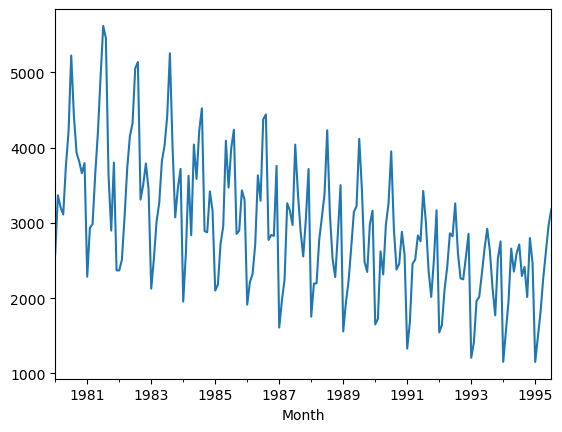

In [145]:
df['Fortified'].plot()

In [146]:
# Seasonal decomposition
result = seasonal_decompose(
    df['Fortified'],
    model='additive',
    period=12,
    extrapolate_trend='freq'
    )

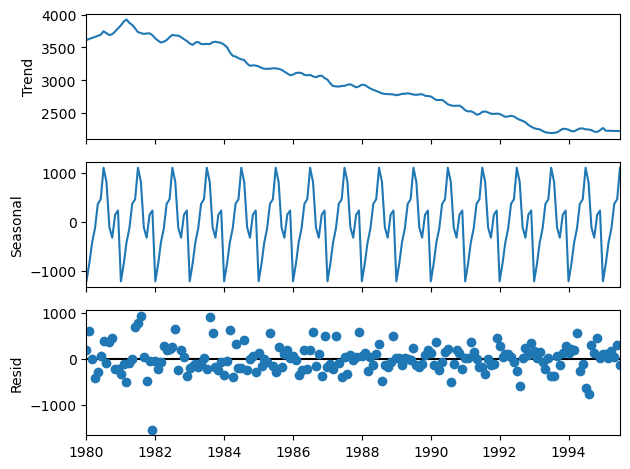

In [147]:
# Plot
fig = result.plot(observed=False)

In [148]:
result.trend

Month
1980-01-01    3612.558615
1980-02-01    3628.445124
1980-03-01    3644.331634
1980-04-01    3660.218143
1980-05-01    3676.104652
                 ...     
1995-03-01    2226.459887
1995-04-01    2225.287685
1995-05-01    2224.115482
1995-06-01    2222.943279
1995-07-01    2221.771076
Name: trend, Length: 187, dtype: float64

In [149]:
# Augmented Dickey-Fuller test
results = adfuller(df['Fortified'])
p_value = results[1]
print('p-value: %f' % p_value)

p-value: 0.785532


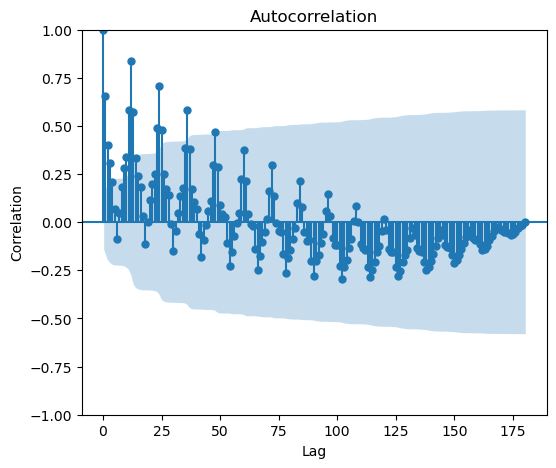

In [150]:
# Plotting ACF
fig,axe=plt.subplots(figsize=(6,5))
axe.set_xlabel('Lag')
axe.set_ylabel('Correlation')
fig=plot_acf(df['Fortified'],ax=axe, alpha=0.05, lags=180)

In [151]:
# Creating an MA(2) model
fort = df['Fortified']
model = ARIMA(fort, order=(50, 0, 20)).fit()
forecast = model.predict(start=len(fort)-1, end=len(fort) + 20)

C:\Users\Alexey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alexey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alexey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alexey\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Alexey\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA 

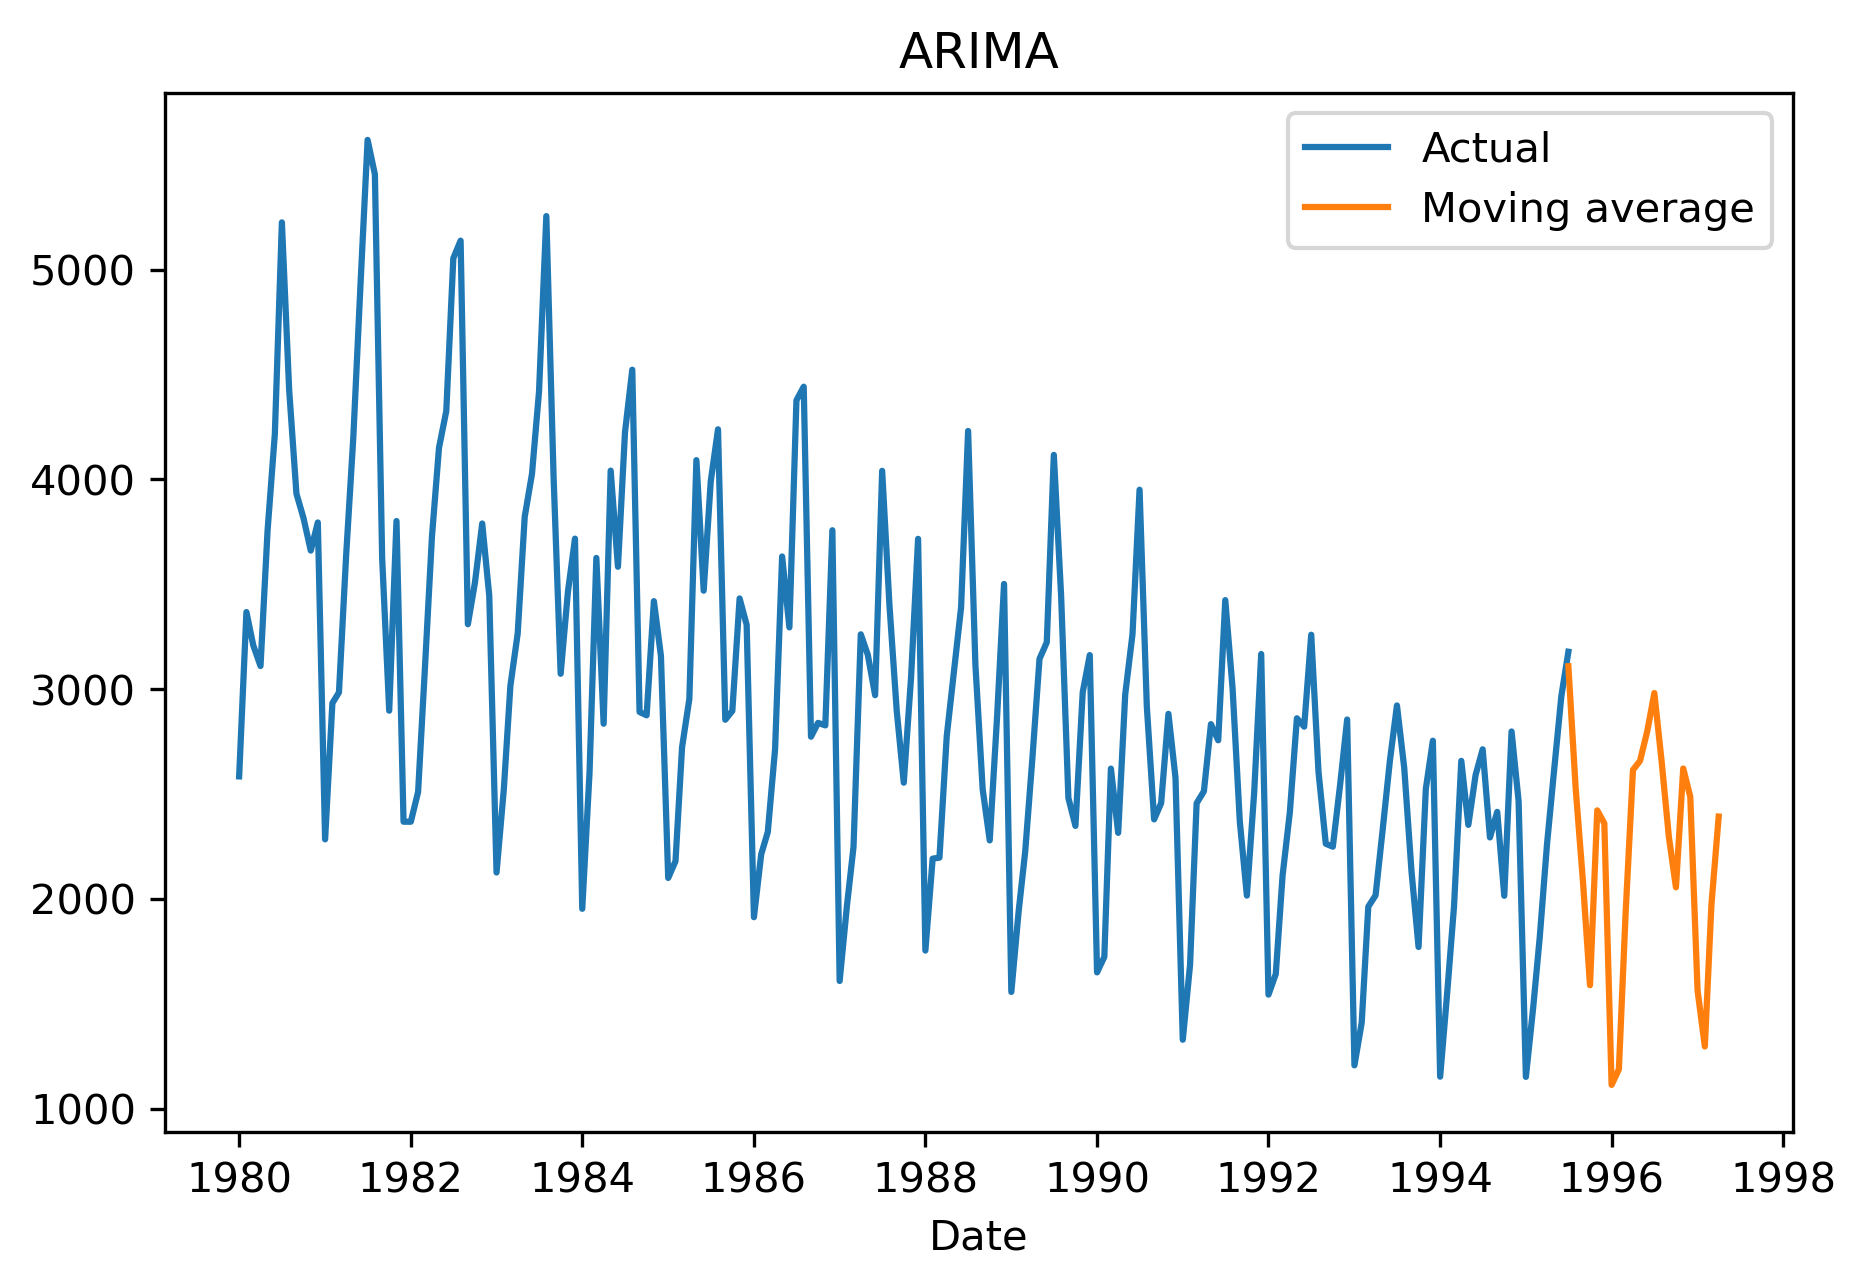

In [152]:
# Plotting
fig, ax = plt.subplots(figsize=(7, 4.5), dpi=300)
ax.plot(df['Fortified'], label = "Actual")
ax.plot(forecast, label = "Moving average")
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

# Labelling 
plt.xlabel("Date")
plt.title("ARIMA")
plt.legend()

C:\Users\Alexey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alexey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alexey\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


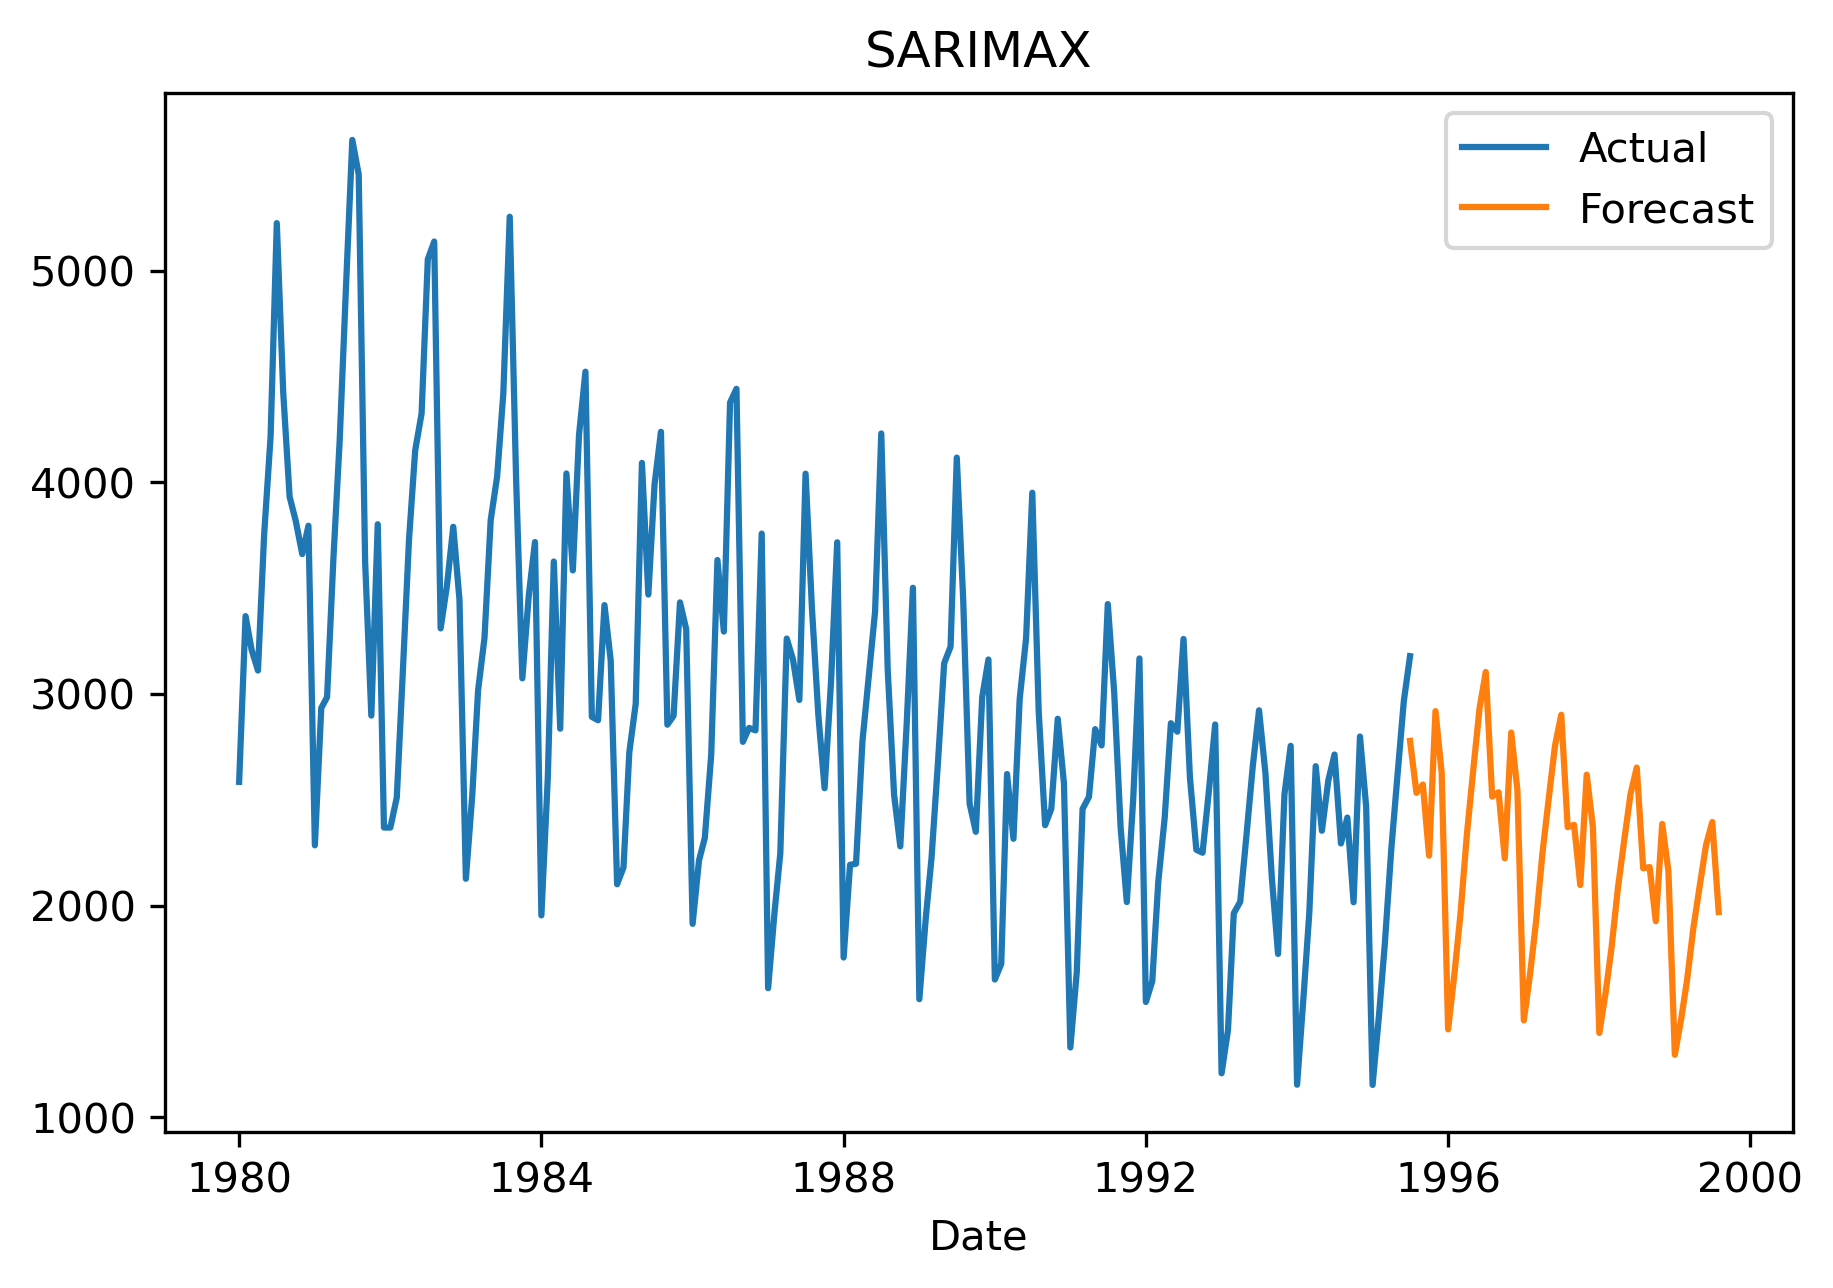

In [153]:
# Seasonality from SARIMAX
fortified = df['Fortified']
results = SARIMAX(
    fortified, order=(5,0,0), seasonal_order=(1,0,0,12)
    ).fit(disp=0)
forecast = results.predict(start=len(df)-1, end=len(df) + 48)
# Plotting
fig, ax = plt.subplots(figsize=(7, 4.5), dpi=300)
ax.plot(df['Fortified'], label = "Actual")
ax.plot(forecast, label = "Forecast")
# Labelling 
plt.xlabel("Date")
plt.title('SARIMAX')
plt.legend()

In [154]:
predictions = results.predict(start=df.index.min(), end=df.index.max())
# Evaluation metrics
mae = mean_absolute_error(fortified, predictions)
mse = mean_squared_error(fortified, predictions)
mape = mean_absolute_percentage_error(fortified, predictions)
r2 = r2_score(fortified, predictions)
print("MAE: {0}".format(mae))
print("MSE: {0}".format(mse))
print("MAPE: {0}".format(mape))
print("R2: {0}".format(r2))

MAE: 314.509711544689
MSE: 202794.53827131115
MAPE: 0.10737181282186782
R2: 0.7361006249792204


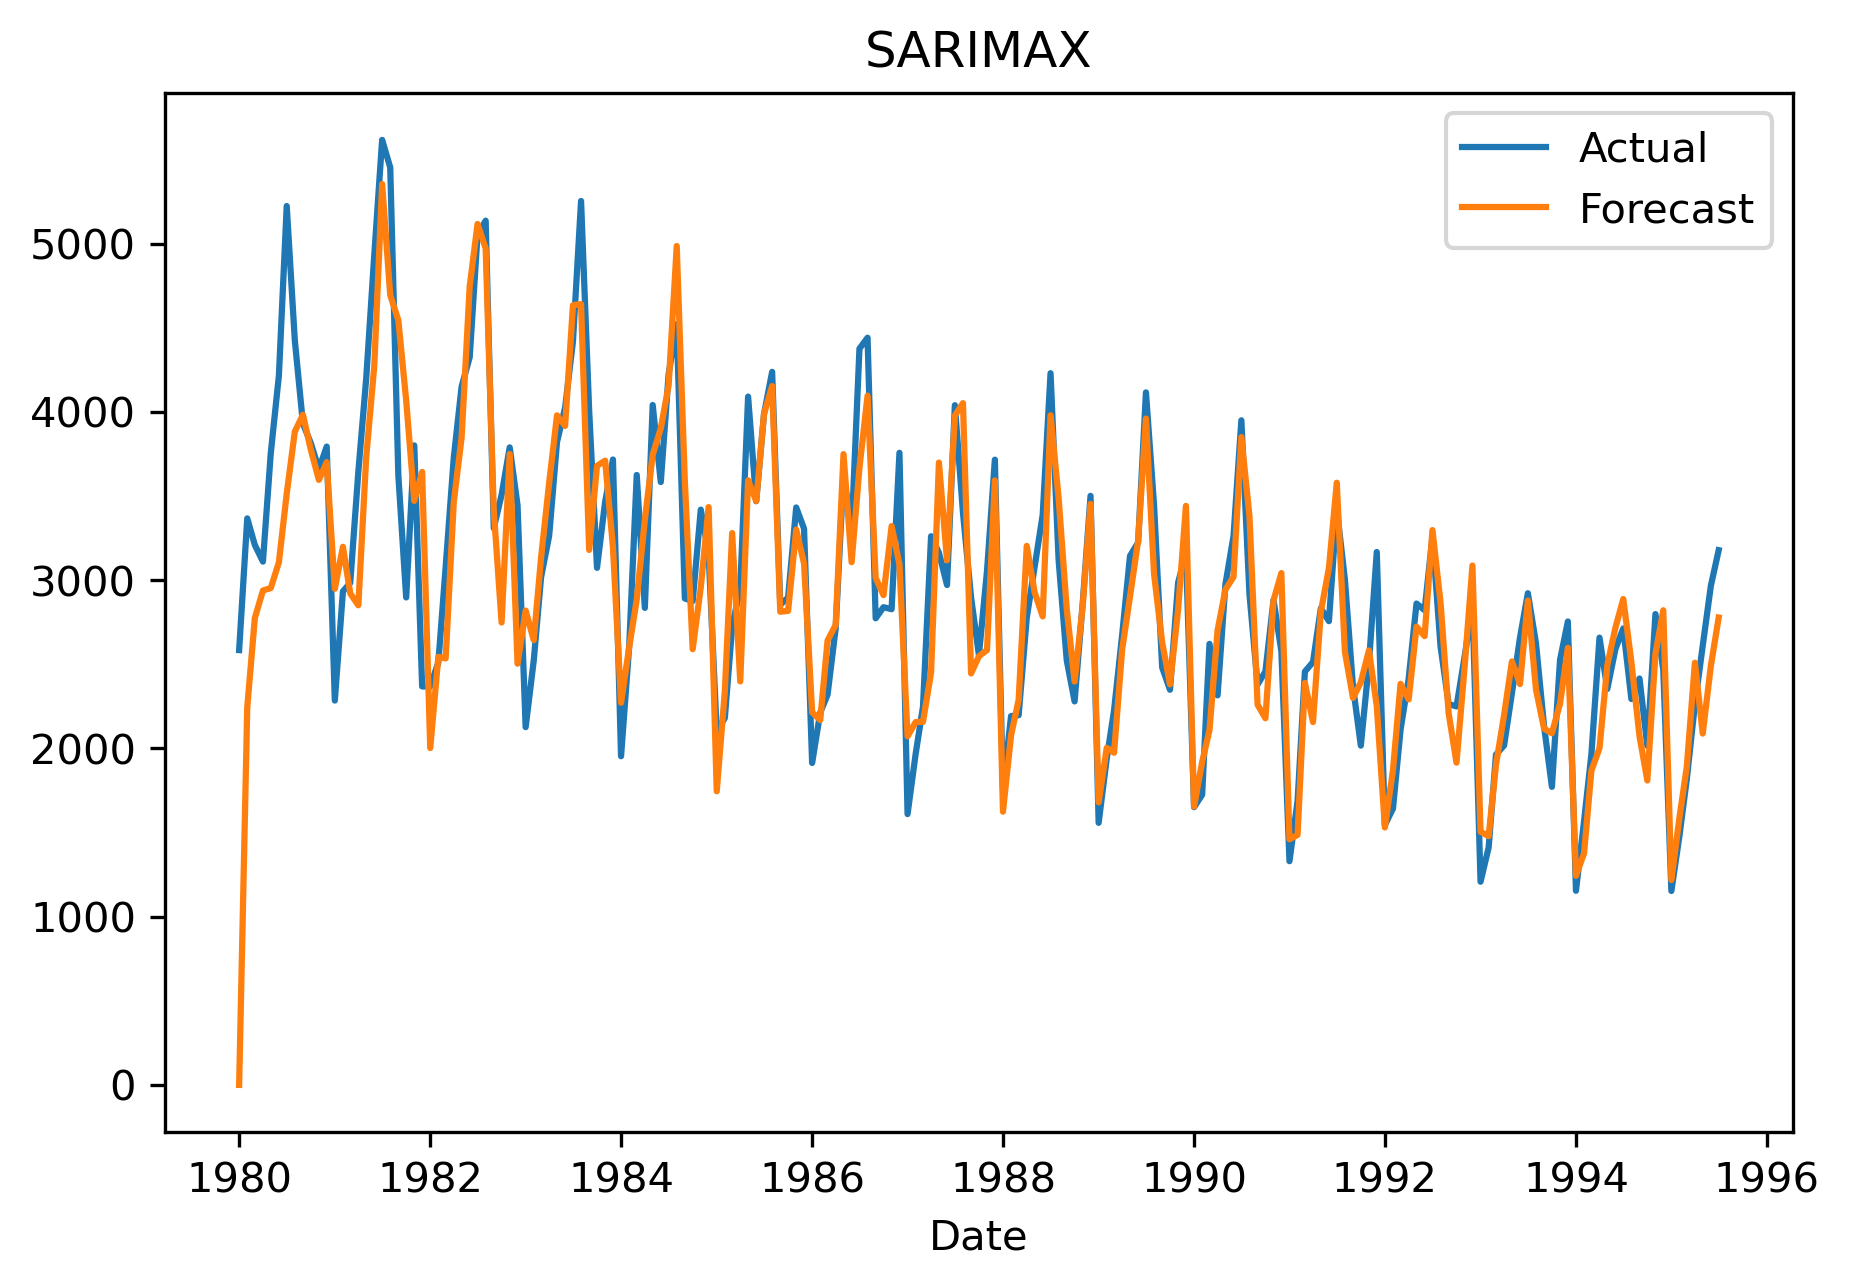

In [155]:
# Plotting
fig, ax = plt.subplots(figsize=(7, 4.5), dpi=300)
ax.plot(df['Fortified'], label = "Actual")
ax.plot(predictions, label = "Forecast")

# Labelling 
plt.xlabel("Date")
plt.title('SARIMAX')
plt.legend()